AST425 2022/23
Lisa Nasu-Yu

In [ ]:
TODO :
    re-parametrize for flat power law

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import scipy.stats as stats
import scipy.integrate as integrate
from sklearn.neighbors import KernelDensity
from skimage import measure
from tqdm.notebook import tqdm

equation functions

In [2]:
def m12chirp(m1):
    "Convert m1 to chirp mass, assuming equal mass ratio"
    return 2**(-1/5) * m1

def chirp2m1(chirp):
    "Convert chirp mass to m1, assuming equal mass ratio"
    return 2**(1/5) * chirp

def z(D_L, H0, omega_m):
    '''
    Estimate z to error 1e-10 for D_L, H0, omega_m, and flat universe.
    Parameters:
        D_L: Luminosity distance (Gpc), float
        H0: Hubble constant (km/s/Mpc), float
        omega_m: omega_m today, float
    Returns:
        z: redshift, float
    '''
    D_L = D_L * 1e3 # convert Gpc to Mpc
    H0 = (H0 * u.km / (u.s*u.Mpc)).to(1/u.s).value
    Omega_m0 = omega_m
    Omega_lambda0 = 1 - Omega_m0
    z_prev = 0
    z = 5
    integral = integrate.quad(lambda x: 1/np.sqrt(Omega_m0*(1+x)**3 + Omega_lambda0), 0, z)
    D_L_calc = const.c.to(u.Mpc/u.s).value * (1+z) / H0 * integral[0]
    while np.abs(D_L - D_L_calc) > 1e-10:
        if (D_L - D_L_calc) > 0: 
            z, z_prev = z + np.abs(z - z_prev) / 2, z
        else:
            z, z_prev = z - np.abs(z - z_prev) / 2, z
        integral = integrate.quad(lambda x: 1/np.sqrt(Omega_m0*(1+x)**3 + Omega_lambda0), 0, z)
        D_L_calc = const.c.to(u.Mpc/u.s).value * (1+z) / H0 * integral[0]
    return z

distribution functions

In [3]:
class D_L_gen(stats.rv_continuous):
    "D_L distribution, flat distribution in Euclidean volume"
    def _pdf(self, x, DL_max):
        return 4*np.pi*x**2 / ((4/3)*np.pi*DL_max**3)
    def _ppf(self, q, DL_max):
        return DL_max * q**(1/3)

class Power_gen(stats.rv_continuous):
    "Power law distribution"
    def _pdf(self, x, xmin, index):
        x = chirp2m1(x)
        return ((index-1)/xmin)*(x/xmin)**(-index)
    def _ppf(self, q, xmin, index):
        return q**(-1/(index - 1)) * xmin

class M_gen(stats.rv_continuous):
    "Mass distribution, power law & gaussian mixture distribution"
    def _pdf(self, x, power_pct, xmin, index, gloc, gscale):
        x = chirp2m1(x)
        gauss_pct = 1 - power_pct
        gauss_dist = stats.norm.pdf(x, loc=gloc, scale=gscale)*gauss_pct
        power_dist = ((index-1)/xmin)*(x/xmin)**(-index)*power_pct
        return gauss_dist + power_dist
    def _rvs(self, power_pct, xmin, index, gloc, gscale, size=1000, 
             random_state=np.random.RandomState(None)): 
        sample_N = size[0]
        # gauss component
        gauss_pct = 1 - power_pct
        gauss_rvs = stats.norm.rvs(loc=gloc, scale=gscale, size=int(round(sample_N*gauss_pct)))
        # power component
        power_dist = Power_gen(a=m12chirp(5), b=m12chirp(80))
        power_rvs = power_dist.rvs(xmin, index, size=int(round(sample_N*power_pct)))
        full_rvs = np.concatenate((gauss_rvs, power_rvs))
#         np.random.shuffle(full_rvs)
        return m12chirp(full_rvs)
    
class M_2feat_gen(stats.rv_continuous):
    "Mass distribution, power & 2 gaussian peaks mixture distribution"
    def _pdf(self, x, power_pct, gauss_pct, xmin, index, gloc1, gscale, gloc2):
        x = chirp2m1(x)
        gauss_dist1 = stats.norm.pdf(x, loc=gloc1, scale=gscale)*gauss_pct
        gauss_dist2 = stats.norm.pdf(x, loc=gloc2, scale=gscale)*gauss_pct
        power_dist = ((index-1)/xmin)*(x/xmin)**(-index)*power_pct
        return gauss_dist1 + gauss_dist2 + power_dist
    def _rvs(self, power_pct, gauss_pct, xmin, index, gloc1, gscale, gloc2, 
             size=1000, random_state=np.random.RandomState(None)): 
        sample_N = size[0]
        # gauss components
        gauss_rvs1 = stats.norm.rvs(loc=gloc1, scale=gscale, size=int(round(sample_N*gauss_pct)))
        gauss_rvs2 = stats.norm.rvs(loc=gloc2, scale=gscale, size=int(round(sample_N*gauss_pct)))
        # power component
        power_dist = Power_gen(a=m12chirp(5), b=m12chirp(80))
        power_rvs = power_dist.rvs(xmin, index, size=int(round(sample_N*power_pct)))
        full_rvs = np.concatenate((gauss_rvs1, gauss_rvs2, power_rvs))
#         np.random.shuffle(full_rvs)
        return m12chirp(full_rvs)
    
def evolution(M_sample, m, range_min, range_max):
    '''
    Apply evolution of form M_evolution = M + m*D_L
    Parameters:
        M_sample: Mass sample, array
        m: slope of linear evolution, float
        range_min: min N/index of evolving feature, float
        range_max: max N/index of evolving feature, float
    Returns:
        M_evo_sample: source frame mass sample with evolution
        Mz_evo_sample: redshifted mass sample with evolution
    '''
    # apply evolution to source frame
    M_evo_sample = np.copy(M_sample)
    M_evo_sample[int(N*range_min):int(N*range_max)] += D_L_sample[int(N*range_min):int(N*range_max)]*m
    # redshift
    Mz_evo_sample = M_evo_sample * zplus1[np.where(h0_range==H0)[0][0]]
    return M_evo_sample, Mz_evo_sample
    
def resample(Mz_pop, Dl_pop, zplus1, N):
    '''
    Resample from Mz_pop and Dl_pop
    Parameters:
        Mz_pop: redshifted mass sample, array
        Dl_pop: luminosity distance sample, array
        zplus1: redshifts given luminosity distances Dl_pop, for varying H_0, array
        N: resample size
    Return: 
        M_z_resample: resampled mass
        D_L_resample: resampled luminosity distance
        z_resample: resampled redshift
    '''
    M_z_resample = np.zeros(N)
    D_L_resample = np.zeros(N)
    z_resample = np.zeros((np.shape(zplus1)[0], N))
    rng = np.random.default_rng()
    for n in range(N):
        ind = rng.integers(len(Mz_pop))
        M_z_resample[n] = Mz_pop[ind]
        D_L_resample[n] = Dl_pop[ind]
        for i in range(np.shape(zplus1)[0]):
            z_resample[i][n] = zplus1[i][ind]
    return M_z_resample, D_L_resample, z_resample

KDE functions

In [4]:
def kde_meshgrid(NMz, NDL):
    mgrid = np.logspace(0, 2.5, NMz)
    dgrid = np.linspace(0, max_D_L, NDL)
    M, D = np.meshgrid(mgrid, dgrid)
    return np.ndarray.flatten(M), np.ndarray.flatten(D)

def kde(Msample, Dsample, M, D, band=0.5):
    kdefit = KernelDensity(kernel='gaussian', bandwidth=band).fit(
        np.transpose([Msample, Dsample]))
    score_grid = np.transpose([M, D])
    kdescore = kdefit.score_samples(score_grid)
    return kdescore

analysis functions

In [115]:
def find_feats(Mz, DL, plot=False):
    '''
    Find features in mass distribution
    Parameters:
        Mz: redshifted mass sample, array
        DL: luminosity distance sample, array
        plot: True if plot KDE & features, bool
    Returns:
        mean_feats: running mean of feature contours, array
    '''
    scores = kde(Mz, DL, M, D, band=0.5)
    # derivative & 2nd derivative of KDE along mass component
    derivs = np.gradient(np.reshape(scores, (Nd,Nm)), axis=1)
    derivs2 = np.gradient(np.reshape(derivs, (Nd,Nm)), axis=1)
    # contours at deriv=0
    contours = measure.find_contours(derivs, 0)
    # filter contours
    features = []
    for contour in contours:
        temp = []
        for c in contour:
            # check overdense peak (not well)
            if derivs2[int(round(c[0])), int(c[1])] < 0:
                temp.append(c)
        temp = np.array(temp)
        if len(temp) > 0:
            # check spans large range in distance
            if (np.max(temp[:,0]) - np.min(temp[:,0])) > Nd*0.8 and (len(temp) > Nd*0.6):
                # check not no M-D correlation 
                if (np.max(temp[:,1]) - np.min(temp[:,1])) > \
                (max(16, np.max(temp[:,0]) - np.min(temp[:,0])))**(1/4):
                    # Check increasing M-D correlation
                    if np.polyfit(dd*temp[:,0], dmlog*temp[:,1], 1)[0] > 0:
                        features.append(temp)
    if plot:
        # plot KDE & contours
        plot_kde(D, M, derivs.flatten())
        for contour in contours:
            plt.plot(dd*contour[:,0], dmlog*contour[:,1], color='white')
        plt.show()
        # plot features
        plt.xlabel(r'$D_L$ (Gpc)')
        plt.ylabel(r'$log(\mathcal{M}_{z})$ ($M_{\odot}$)')
        plt.yscale('log')
        plt.plot(DL, Mz, 'r,', alpha=0.5)
    # calculate running mean of contours
    mean_feats = []
    for feat in features:
        t = 10 # running mean interval
        temp = []
        for i in range(t,len(feat)-t):
            temp_pt = [feat[i,0], np.mean([feat[i+n,1] for n in range(-t,t+1)])]
            temp.append(np.array(temp_pt))
        for i in range(t, 0, -1):
            temp_pt = [feat[-i,0], np.mean([feat[-i+n,1] for n in range(-i,i)])]
            temp.append(np.array(temp_pt))
        mean_feats.append(np.array(temp))
        if plot:
            # plot features
            plt.plot([dd*t[0] for t in temp], [10**(dmlog*t[1]) for t in temp], marker='.')
            plt.fill_between([dd*f[0] for f in temp], [10**(dmlog*f[1]+2*dmlog) for f in temp], 
                             [10**(dmlog*f[1]-2*dmlog) for f in temp], color='gray', alpha=0.5)
    return mean_feats

def fit_feats(features, Mz, DL, zplus1, mrange, mmin, plot=False):
    '''
    Linear fit features
    Parameters:
        features: features found in sample from function find_feats, array
        Mz: redshifted mass sample, array
        DL: luminosity distance sample, array
        zplus1: z+1, where z is redshift for luminosity distances DL for varying H0's, array
        plot: True if plot filtered features, bool
    Returns:
        fits: slopes and y-intercepts from linear fits of filtered features, array
    '''
    # find points within dmlog and dd of features
    pts = [[] for _ in features]
    ms = []
    for i in range(len(Mz)):
        for n, contour in enumerate(features):
            for c in contour:
                if np.abs(np.log10(Mz[i]) - dmlog*c[1]) <= dmlog and \
                np.abs(DL[i] - dd*c[0]) < dd:
                    pts[n].append(i)
                    break
    # linear fit points around each feature for varying h0
    fits = []
    for i,feat in enumerate(pts):
        if len(feat)>3: # check > 3 points
            m = np.random.random()*mrange[i] + mmin[i]
            ms.append(m)
            temp = []
            for h,zplus1h0 in enumerate(zplus1):
                slope, y = np.polyfit(DL[feat], Mz[feat]/zplus1h0[feat] - m*DL[feat], 1)
                temp.append([slope,y])
            fits.append(temp)
            if plot: # plot fit
                plt.plot(h0_range, [np.abs(s[0]) for s in temp], marker='o')
    return fits, ms

def bootstrap_fit(M_z_sample, D_L_sample, zplus1, N, iterations, Nf, mrange, mmin):
    '''
    Find and fit features and slopes of linear evolution in resampled mock data
    Parameters:
        Mz: redshifted mass sample, array
        DL: luminosity distance sample, array
        zplus1: z+1, where z is redshift for luminosity distances DL for varying H0's, array
        N: resampling size, int
        iterations: Number of bootstrap iterations, int
        Nf: Number of features, int
        mrange: (max slope - min slope) of linear evolution to try in each feature, array
        mmin: minimum slopes of linear evolution to try in each feature, array
    Returns:
        btsp_h0s: slopes (H0) evaluated in linear fits, array
        btsp_m: y-int (location of features) evaluated in linear fits, array
        btsp_evo: slopes of linear evolution used in linear fits, array
    '''
    btsp_h0s = []
    btsp_m = []
    btsp_evo = []
    cutoff = []
    feat1 = []
    feat2 = []
    resample_features = [feat1, feat2]
    for i in tqdm(range(iterations)):
        M_z_resample, D_L_resample, z_resample = resample(M_z_sample, D_L_sample, zplus1, N)
        features = find_feats(M_z_resample, D_L_resample)
        # check all expected features picked up, then fit
        if len(features) == Nf:
            if np.all([np.mean([t[1] for t in features[j]]) < 
                       np.mean([t[1] for t in features[j+1]]) 
                       for j in range(Nf-1)]) == True:
                for n, feat in enumerate(features):
                    resample_features[n].append(feat)
                fits, ms = fit_feats(features, M_z_resample, D_L_resample, z_resample,
                                     mrange, mmin)
                btsp_h0s.append([np.abs(np.array(fit).T[0]) for fit in fits])
                btsp_m.append([np.abs(np.array(fit).T[1]) for fit in fits])
                btsp_evo.append([m for m in ms])
    # plot features used in fits
    for feat in resample_features:
        plt.figure()
        plt.yscale('log')
        for btsp in feat:
            if len(btsp) > 0:
                plt.plot([dd*t[0] for t in btsp], [10**(dmlog*t[1]) for t in btsp], marker='.')
        plt.show()
    return btsp_h0s, btsp_m, btsp_evo

def evo_analysis(evos, save=False):
    '''
    Constrain slopes of linear evolution in each mass feature
    Parameters:
        evos: slopes of evolution from linear fits for each feature, array
    Returns:
        means: mean linear evolution slope for each feature, array
        sigma1ps: min linear evolution slope for each feature to 68% confidence, array
        sigma1ms: max linear evolution slope for each feature to 68% confidence, array'''
    means = []
    sigma1ps = []
    sigma1ms = []
    for i in range(np.shape(evos)[1]):
        evo = [ev[i] for ev in evos]
        plt.xlabel(r'|m| ($M\odot/Gpc$)')
        plt.ylabel('probability density')
        plt.hist(evo, color='navy', density=True)
        mean = np.mean(evo)
        sigma1p = np.percentile([e for e in evo if e>=mean], 68)
        sigma1m = np.percentile([e for e in evo if e<mean], 100-68)
        sigma2p = np.percentile([e for e in evo if e>=mean], 95)
        sigma2m = np.percentile([e for e in evo if e<mean], 5)
        means.append(mean)
        sigma1ps.append(sigma1p)
        sigma1ms.append(sigma1m)
        plt.fill_between([sigma1m, sigma1p], [16,16], color='slateblue', alpha=0.8, label=r'1$\sigma$')
        plt.fill_between([sigma2m, sigma2p], [16,16], color='slateblue', alpha=0.5, label=r'2$\sigma$')
        plt.legend()
        if save:
            plt.savefig('slope05.pdf')
        plt.show()
        print('mean: {}, 1sigma: {}-{}, 2sigma: {}-{}'.format(mean, sigma1m, sigma1p, 
                                                              sigma2m, sigma2p))
    return means, sigma1ps, sigma1ms

def analysis(feats, btsp_h0s, btsp_m, h0_range, save=False):
    '''
    Constrain H0 using each mass feature
    Parameters:
        feats: array of size = number of features, array
        btsp_h0s: slopes (H0) evaluated from linear fits, array
        btsp_m: y-int (location of features) evaluated from linear fits, array
        h0_range: range of H0s tested in linear fits, array
        save: True to result plots, bool
    Returns:
        mean: mean H0 for each feature, array
        mean_peak: mean locations of mass features, array
        '''
    for i in feats:
        means = []
        peaks = []
        # find h0 where slope is minimized for each re-iteration
        for n,ah in enumerate(btsp_h0s):
            try:
                idx = np.where(ah[i] == np.min(ah[i]))[0][0]
                means.append(idx)
                peaks.append(btsp_m[n][i][idx])
            except:
                pass
        # mean h0 and uncertainties
        mean = np.mean(h0_range[means])
        median = np.median(h0_range[means])
        sigma1p = np.percentile([h0 for h0 in h0_range[means] if h0>=mean], 68)
        sigma1m = np.percentile([h0 for h0 in h0_range[means] if h0<mean], 100-68)
        sigma2p = np.percentile([h0 for h0 in h0_range[means] if h0>=mean], 95)
        sigma2m = np.percentile([h0 for h0 in h0_range[means] if h0<mean], 5)
        print('H0')
        print('mean: {}, median: {}'.format(mean, median))
        print('1sigma: {},+{}, 2sigma: {},+{}'.format(sigma1m-mean, sigma1p-mean,
                                                      sigma2m-mean, sigma2p-mean))
        plt.xlabel(r'H_0 (km/s/Mpc)')
        plt.ylabel('Probability')
        plt.fill_between([sigma1m, sigma1p], 0, 0.3, color='slateblue', 
                         alpha=0.6, label=r'1$\sigma$')
        plt.fill_between([sigma2m, sigma2p], 0, 0.3, color='slateblue',
                         alpha=0.3, label=r'2$\sigma$')
        plt.hist(h0_range[means], bins=np.arange(55,86), density=True, align='left', color='navy')
        plt.legend()
        if save:
            plt.savefig(save)
        plt.show()
        # location of peak given slope minimizing h0
        peaks = [chirp2m1(peak) for peak in peaks]
        mean_peak = np.mean(peaks)
        median_peak = np.median(peaks)
        sigma1p_peak = np.percentile([peak for peak in peaks if peak>=mean_peak], 68)
        sigma1m_peak = np.percentile([peak for peak in peaks if peak<mean_peak], 100-68)
        sigma2p_peak = np.percentile([peak for peak in peaks if peak>=mean_peak], 95)
        sigma2m_peak = np.percentile([peak for peak in peaks if peak<mean_peak], 5)
        print('peak')
        print('mean: {}, median: {}'.format(mean_peak, median_peak))
        print('1sigma: {},+{}, 2sigma: {},+{}'.format(sigma1m_peak-mean_peak,
                                                      sigma1p_peak-mean_peak,
                                                      sigma2m_peak-mean_peak, 
                                                      sigma2p_peak-mean_peak))
        plt.xlabel(r'Feature Location ($\mathcal{M}$)')
        plt.ylabel('Probability')
        plt.fill_between([sigma1m_peak, sigma1p_peak], 0, 1, color='slateblue', 
                         alpha=0.6, label=r'1$\sigma$')
        plt.fill_between([sigma2m_peak, sigma2p_peak], 0, 1, color='slateblue',
                         alpha=0.3, label=r'2$\sigma$')
        plt.hist(peaks, density=True, align='left', color='navy')
        plt.legend()
        if save:
            plt.savefig(save)
        plt.show()
    return mean, mean_peak

plot functions

In [6]:
def plot_samples(DL_sample, Msample, Mz_sample):
    plt.figure(figsize=(5,5))
    plt.title('BBH Redshifted Chirp Mass vs Luminosity Distance')
    plt.xlabel(r'$D_L$ (Gpc)')
    plt.ylabel(r'$log(\mathcal{M}_{z})$ ($M_{\odot}$)')
    plt.plot(DL_sample, np.log10(Msample), '.', label='$\mathcal{M}$')
    plt.plot(DL_sample, np.log10(Mz_sample), '.', alpha=0.5, label=r'$\mathcal{M}_{z}(H_0=68, \Omega_m0=0.3)$')
    plt.legend()
    plt.savefig('1f_dist.pdf')
    plt.show()

def plot_kde(D, M, kde_score):
    plt.figure()
    plt.xlabel(r'$D_L$ (Gpc)')
    plt.ylabel(r'$log(\mathcal{M}_{z})$ ($M_{\odot}$)')
    plt.scatter(D, np.log10(M), c=kde_score, marker=',', vmin=-1, vmax=1)
    plt.grid(alpha=0.5)
    plt.colorbar(label=r'd(KDE)/dM')
#     plt.show()

distribution constants

In [9]:
# distributions lims
max_D_L = 15 # Gpc
min_m1 = 7 # m1, solar mass
max_m1 = 80 # m1, solar mass
chirprange = m12chirp(np.arange(min_m1, max_m1))
h0_range = np.arange(55, 85)
N = 10000
# cosmo params
H0 = 68
OmegaM = 0.3
# create meshgrid
Nm = 50
Nd = 50
M, D = kde_meshgrid(Nm, Nd)
dd = np.diff(D.reshape(Nd,Nm).T[0])[0]
dmlog = np.diff(np.log10(M).reshape(Nd,Nm)[0])[0]

In [10]:
# Set saved=False to generate luminosity distance and redshift samples. note, this is SLOW
# Set saved=True to upload previously saved luminosity distance and redshift samples
saved = True
if not saved:
    # DL sample
    D_L_dist = D_L_gen(name='D_L', a=0, b=max_D_L)
    D_L_sample = D_L_dist.rvs(max_D_L, size=N)
    with open('data.npy', 'wb') as f:
        np.save(f, D_L_sample)

    # redshifts
    zplus1 = np.zeros((len(h0_range), N))
    for n in tqdm(range(len(h0_range))):
        for i,d in enumerate(D_L_sample):
            zplus1[n,i] = z(d, h0_range[n], OmegaM)+1

    with open('dataz.npy', 'wb') as f:
        np.save(f, zplus1)
else:
    D_L_sample = np.load('data.npy')
    zplus1 = np.load('dataz.npy')

1 feature

In [123]:
# generate mass samples
# params = (power_pct, xmin, index, gloc(gauss_mean_m1), gscale(gauss_std_m1))
params = (1e-16, min_m1, 3.5, 34, 2)
# generate mass sample
M_dist = M_gen(name='M', a=m12chirp(min_m1), b=m12chirp(max_m1))
M_sample = M_dist.rvs(*params, size=N)
M_z_sample = M_sample*(zplus1[np.where(h0_range==68)[0][0]])

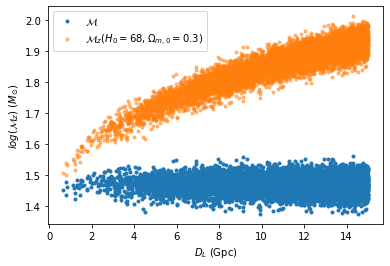

In [124]:
# plot data
plt.figure()
plt.xlabel(r'$D_L$ (Gpc)')
plt.ylabel(r'$log(\mathcal{M}_{z})$ ($M_{\odot}$)')
plt.plot(D_L_sample, np.log10(M_sample), '.', label='$\mathcal{M}$')
plt.plot(D_L_sample, np.log10(M_z_sample), '.', alpha=0.5, label=r'$\mathcal{M}_{z}(H_0=68, \Omega_{m,0}=0.3)$')
plt.legend()
# plt.savefig('1f_dist.pdf')
plt.show()

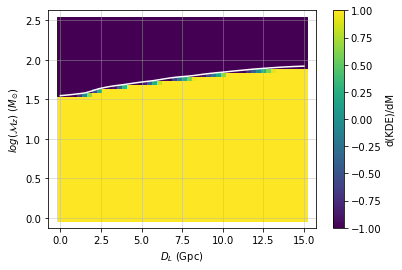

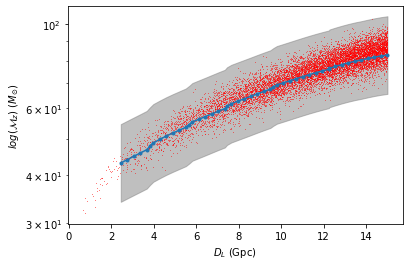

slope: 0.979784530681802


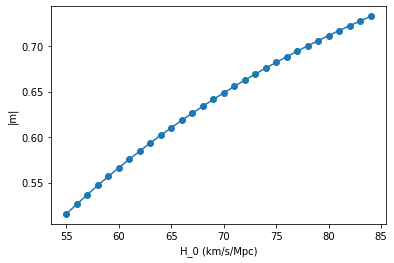

In [127]:
# plot process for a single iteration

# find features
features = find_feats(M_z_sample, D_L_sample, plot=True)
# plt.savefig('1f_contours.pdf')
plt.show()

# fitting H_0
plt.xlabel(r'H_0 (km/s/Mpc)')
plt.ylabel(r'|m|')
m = np.random.random()
print('slope: {}'.format(m))
_ = fit_feats(features, M_z_sample, D_L_sample, zplus1, [1], [0], plot=True)
# plt.savefig('fit_method.pdf')
plt.show()

In [ ]:
# results
btsp_h0s, btsp_m = bootstrap_fit(M_z_sample, D_L_sample, zplus1, N, 50, 1, [1], [0])
analysis(range(0,1), btsp_h0s, btsp_m, h0_range, save=False)

2 features

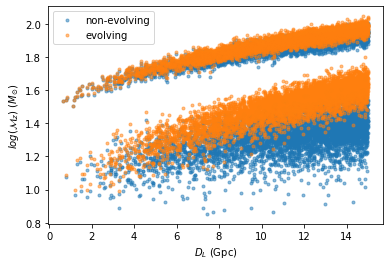

In [11]:
# generate 2 feature mass sample - peaks at 10 & 34
# params = (power_pct, gauss_pct, min_m1, index, gauss1_mean_m1, gauss_std_m1, gauss2_mean_m1)
params_2ft = (1e-16, (1-1e-16)/2, min_m1, 3.5, 34, 2, 10)
# generate mass sample
M_2ft_dist = M_2feat_gen(name='M2ft', a=m12chirp(min_m1), b=m12chirp(max_m1))
M_sample_2ft = M_2ft_dist.rvs(*params_2ft, size=N)
M_z_sample_2ft = M_sample_2ft*zplus1[np.where(h0_range==68)[0][0]]
# apply evolution
M_evo_sample_2ft, Mz_evo_sample_2ft = evolution(M_sample_2ft, 0.2, 0, 0.5)
M_evo_sample_2ft, Mz_evo_sample_2ft = evolution(M_evo_sample_2ft, 0.4, 0.5, 1)
# plot mock data
plt.figure()
plt.xlabel(r'$D_L$ (Gpc)')
plt.ylabel(r'$log(\mathcal{M}_{z})$ ($M_{\odot}$)')
plt.plot(D_L_sample, np.log10(M_z_sample_2ft), '.', alpha=0.5, label='non-evolving')
plt.plot(D_L_sample, np.log10(Mz_evo_sample_2ft), '.', alpha=0.5, label='evolving')
plt.legend()
plt.show()

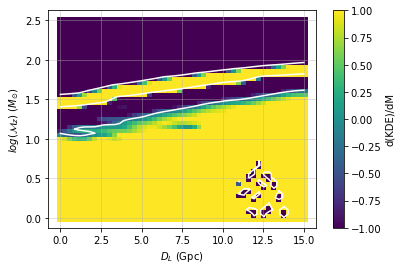

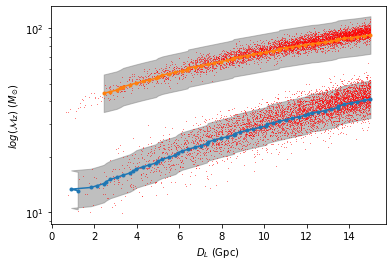

In [12]:
features_evo_2ft = find_feats(Mz_evo_sample_2ft, D_L_sample, plot=True)
# plt.savefig('1f_contours.pdf')
plt.show()

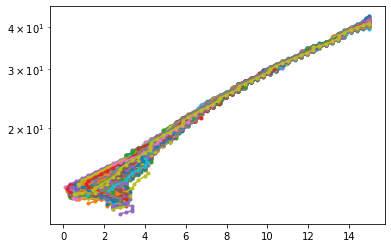

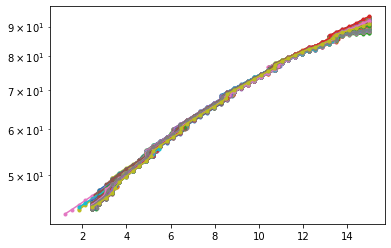

In [13]:
# run for evolution slopes within [0,1)
btsp_h0s, btsp_m, btsp_evo = bootstrap_fit(Mz_evo_sample_2ft, D_L_sample, zplus1, N, 1000, 
                                           2, [1,1], [0,0])

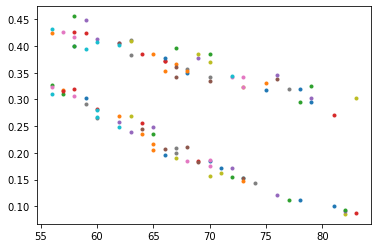

In [93]:
# determine iterations with best fit H0s for both features within 5M of each other
good_idx = []
for i, b in enumerate(btsp_h0s):
    if np.abs(np.diff([h0_range[np.where(b[n]==np.min(b[n]))[0][0]] for n in range(2)])) < 5:
        if np.all([h0_range[np.where(b[n]==np.min(b[n]))[0][0]] != min(h0_range) for n in range(2)]):
            if np.all([h0_range[np.where(b[n]==np.min(b[n]))[0][0]] != max(h0_range) for n in range(2)]):
                good_idx.append(i)
                plt.plot([h0_range[np.where(b[n]==np.min(b[n]))[0][0]] for n in range(2)], 
                         [btsp_evo[i][n] for n in range(2)], '.')

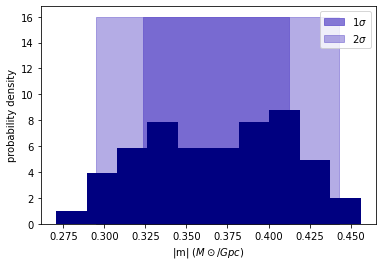

mean: 0.3690112428594006, 1sigma: 0.323252256789146-0.41229426035774847, 2sigma: 0.2947942208868276-0.44268311633804736


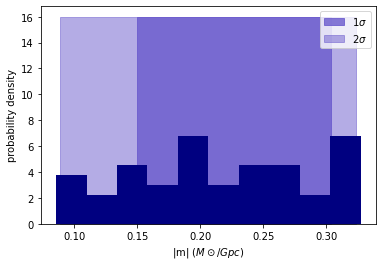

mean: 0.21225526806094958, 1sigma: 0.14933370475954877-0.30405862503122494, 2sigma: 0.08876454471945266-0.3233343384957064


In [94]:
# constrain linear evolution slope
mean_evos, max_evos, min_evos =evo_analysis(np.array(btsp_evo)[good_idx])

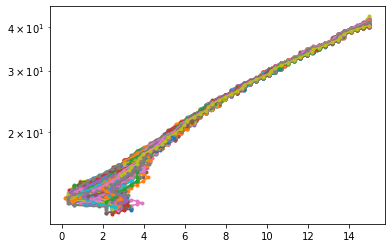

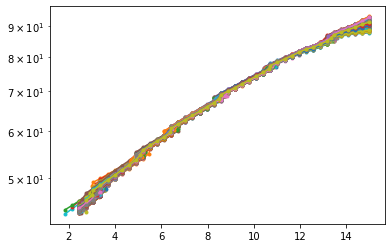

In [108]:
# run again for constrained evolution slopes, 68% confidence
btsp_h0s, btsp_m, btsp_evo = bootstrap_fit(Mz_evo_sample_2ft, D_L_sample, zplus1, N, 500, 2,
                                          [max_evos[i]-min_evos[i] for i in range(2)], min_evos)

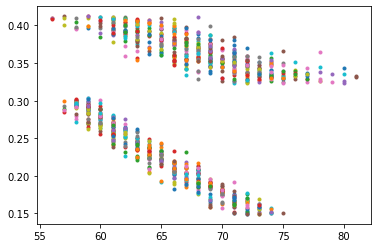

In [131]:
# determine iterations with best fit H0s > 55 and < 85
good_idx = []
for i, b in enumerate(btsp_h0s):
    if np.abs(np.diff([h0_range[np.where(b[n]==np.min(b[n]))[0][0]] for n in range(2)])) < 30:
        if np.all([h0_range[np.where(b[n]==np.min(b[n]))[0][0]] != min(h0_range) for n in range(2)]):
            if np.all([h0_range[np.where(b[n]==np.min(b[n]))[0][0]] != max(h0_range) for n in range(2)]):
                good_idx.append(i)
                plt.plot([h0_range[np.where(b[n]==np.min(b[n]))[0][0]] for n in range(2)], 
                         [btsp_evo[i][n] for n in range(2)], '.')

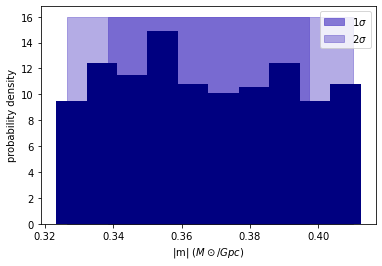

mean: 0.36714708058237866, 1sigma: 0.3386246586809004-0.3970866547442113, 2sigma: 0.32659393972274137-0.4101262035211533


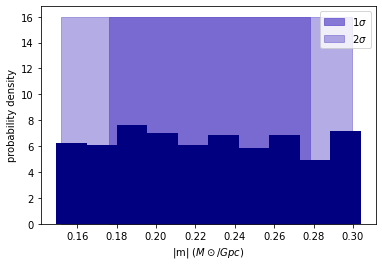

mean: 0.22603456551518614, 1sigma: 0.17598304027252065-0.2782844358809803, 2sigma: 0.15191058749858882-0.29947260828442346
H0
mean: 67.87775551102204, median: 68.0
1sigma: -5.877755511022045,+5.122244488977955, 2sigma: -8.877755511022045,+10.122244488977955


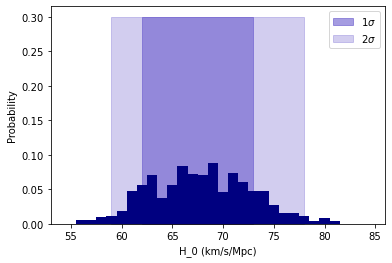

peak
mean: 10.255081578688712, median: 10.238131985768646
1sigma: -0.290107877006724,+0.32404133900038623, 2sigma: -0.6091004635611377,+0.6598746624436735


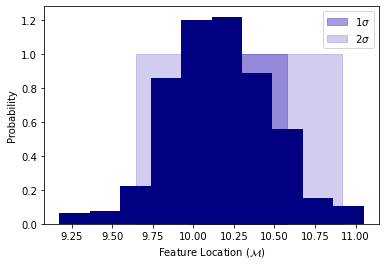

H0
mean: 64.85170340681363, median: 65.0
1sigma: -4.851703406813627,+5.148296593186373, 2sigma: -6.851703406813627,+8.148296593186373


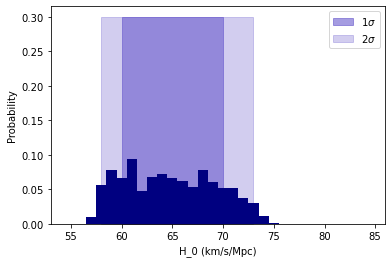

peak
mean: 34.46146847868409, median: 34.453883186699585
1sigma: -0.758109398699041,+0.7512304985167475, 2sigma: -1.2566359310829895,+1.1138138468062024


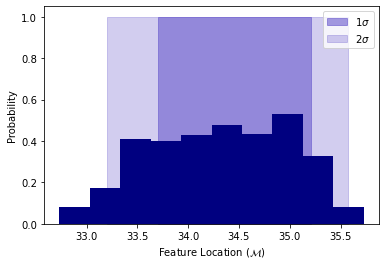

In [132]:
# constrain evolution slopes, H0, and mass peak locations
mean_evos, max_evos, min_evos =evo_analysis(np.array(btsp_evo)[good_idx])
_,_=analysis(range(0,2), np.array(btsp_h0s)[good_idx], 
         np.array(btsp_m)[good_idx], h0_range, save=False)